In [129]:
import glob
import cv2
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import utils.make_density_map_charles as mdm

In [130]:
def get_im_cv2(path, img_width, img_height):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height))#, cv2.INTER_LINEAR)
    return resized

def load_data(path, data_type, img_width, img_height):
    X, X_id, y = [], [], []
    minpix = 2                                  #minimum number of pixels for crater to count
    files = glob.glob('%s*.png'%path)
    print "number of %s files are: %d"%(data_type,len(files))
    for i,fl in enumerate(files):
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl,img_width,img_height) / 255.
        
        #experimenting with bigger contrast
        img[img > 0.] = 1. - img[img > 0.] 
        minn, maxx = np.min(img[img>0]), np.max(img[img>0])
        low, hi = 0.1, 1
        img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn)
        X.append(img)
        X_id.append(fl)
        
        csv = pd.read_csv('%s.csv'%fl.split('.png')[0])
        csv.drop( np.where(csv["Diameter (pix)"] < minpix)[0], inplace=True )
        #target = mdm.make_mask(csv, img, binary=True, truncate=True, rings=True)
        #target = mdm.make_circlering_mask(csv, img, binary=True, truncate=True)
        target = mdm.make_mask(csv, img, binary=True, rings=True, ringwidth=1, truncate=True)
        y.append(target)
    return  X, y, X_id

def read_and_normalize_data(path, img_width, img_height, data_flag):
    if data_flag == 0:
        data_type = 'train'
    elif data_flag == 1:
        data_type = 'test'
    data, target, id = load_data(path, data_type, img_width, img_height)
    data = np.array(data).astype('float32')     #convert to numpy, convert to float
    print('%s shape:'%data_type, data.shape)
    return data, target, id

train_data, train_target, train_id = read_and_normalize_data('training_set/', 300, 300, 0)
test_data, test_target, test_id = read_and_normalize_data('test_set/', 300, 300, 0)

number of train files are: 90


NameError: global name 'float32' is not defined

In [2]:
ext = "rings"    #rings or circlerings
train_data=np.load('training_set/train_data_%s_sample.npy'%ext).astype('float32')
train_target=np.load('training_set/train_target_%s_sample.npy'%ext).astype('float32')
test_data=np.load('test_set/test_data_%s_sample.npy'%ext).astype('float32')
test_target=np.load('test_set/test_target_%s_sample.npy'%ext).astype('float32')

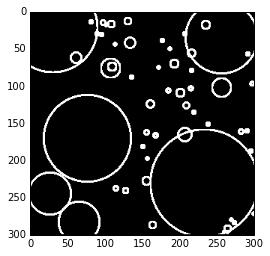

In [79]:
i=6
#plt.imshow(test_data[i], origin='upper', cmap="Greys_r")
plt.imshow(test_target[i], origin='upper', cmap="Greys_r")
plt.savefig('output_dir/circle_test.png')

In [81]:
#http://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/
#https://stackoverflow.com/questions/32287032/circular-hough-transform-misses-circles

img = cv2.imread('output_dir/circle_test.png',0)
#img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

radii = np.arange(1,200,5)

#Hough circles
for i in range(len(radii)-1):
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,5,param1=25,param2=30,minRadius=radii[i],maxRadius=radii[i+1])
    if circles is None: # Skip if no circles are detected - Change here
        continue
    
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),thickness=3)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),thickness=3)

In [52]:
#contours
#https://stackoverflow.com/questions/25504964/opencv-python-valueerror-too-many-values-to-unpack
ret,thresh = cv2.threshold(img,127,255,0)
image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
image = cv2.drawContours(image, contours, -1, (0,255,0), 3)

In [65]:
cimg2 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
image, contours, hierarchy = cv2.findContours(255 - img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
cimg2 = cv2.drawContours(cimg2, contours, -1, color=(0,255,0), thickness=3)

In [114]:
#http://layer0.authentise.com/detecting-circular-shapes-using-contours.html
img = cv2.imread('output_dir/circle_test.png',0)
edge_detected_image = cv2.Canny(img, 75, 200)
_, contours, hierarchy = cv2.findContours(edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_list = []
for contour in contours:
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    if ((len(approx) > 8) & (len(approx) < 23) & (area > 30) ):
        contour_list.append(contour)

circles=cv2.drawContours(img, contour_list,  -1, (0,255,0), 2)

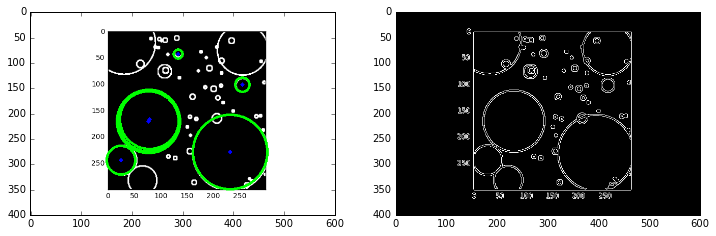

In [116]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=[12, 8])
ax1.imshow(cimg, origin='upper', cmap="Greys_r")
ax2.imshow(edge_detected_image, origin='upper', cmap="Greys_r")

In [90]:
cimg2 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Find contours
contours,_ = cv2.findContours(255 - img, cv2.RETR_LIST, cv.CV_CHAIN_APPROX_NONE)

# Draw all detected contours on image in green with a thickness of 1 pixel
cv2.drawContours(cimg2, contours, -1, color=(0,255,0), thickness=1)

AttributeError: 'module' object has no attribute 'CV_CHAIN_APPROX_NONE'